# Notebook to recreate 

A Discriminative Feature Learning Approach for Deep Face Recognition

Not using the same exact networks so expecting slightly different results

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import jax
import jax.numpy as jnp                # JAX NumPy
from flax import linen as nn           # The Linen API
from flax.training import train_state# Useful dataclass to keep train state
import flax
import optax                           # For SGD

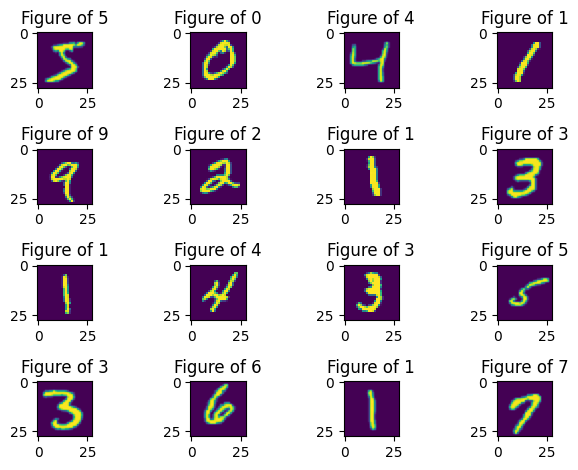

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
import matplotlib.pyplot as plt
import itertools
fig, axs = plt.subplots(4,4)
for n, (i,j) in enumerate(itertools.product(range(4), range(4))):
    axs[i,j].imshow(x_train[n])
    axs[i,j].set_title(f"Figure of {y_train[n]}")
fig.tight_layout()

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
import numpy as np
class MNISTData(keras.utils.Sequence):

    def __init__(self, x_in, y_in, batch_size, shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = jnp.expand_dims(jnp.array(x_in), -1)/255
        self.y = jnp.array(y_in)
        self.datalen = len(y_in)
        self.on_epoch_end()

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]
        return x_batch, y_batch
    
    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)
train = MNISTData(x_train, y_train, 32)
test = MNISTData(x_test, y_test, 32)

# Convelutional neural network - adapted from flax tutorial.

We do one adaptation which is add a penultimate layer with 2 dimenions for the center loss part.

This is so we have a low dimensional representation of each figure in 2d space.

# A standard CNN.

output is the logits and the latent representation of each image.

We can re-use this model for both center loss & standard

In [8]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.PReLU()(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.PReLU()(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.PReLU()(x)
        x = nn.Dense(features=16)(x)
        x = nn.PReLU()(x)
        x = nn.Dense(features=8)(x)
        x = nn.soft_sign(x)
        latent_features = nn.Dense(features=2, use_bias=False)(x)
        out = nn.Dense(features=10, name="latent_features")(latent_features)
        return out, latent_features
        
    


# Core components

Cross entropy loss, metrics, code to create the initial state

The code to train for a full epoch.

These parts will need to change quite majorly for center loss

In [9]:
def cross_entropy_loss(logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)

    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    pred_label = jnp.argmax(logits, -1)
    accuracy = jnp.mean(pred_label == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    cnn = CNN()
    #1,28,28 is the image size (batch size 1)
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)


@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits, _ = CNN().apply({'params': params}, batch[0])
        loss = cross_entropy_loss(logits=logits, labels=batch[1])
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch[1])
    return state, metrics


@jax.jit
def eval_step(params, batch):
    logits, _ = CNN().apply({'params': params}, batch[0])
    return compute_metrics(logits=logits, labels=batch[1])


def train_epoch(state, train_ds, epoch, rng):
    """Train for a single epoch."""
    batch_metrics = []
    for batch in train_ds:
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {}
    for k in batch_metrics_np[0]:
        data = [metrics[k] for metrics in batch_metrics_np]
        epoch_metrics_np[k] = np.mean(data)

    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))
    train_ds.on_epoch_end()
    return state

def evaluate_epoch(state, dataset):
    """Train for a single epoch."""
    
    batch_metrics = []
    for batch in dataset:
        metrics = eval_step(state.params, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}
    return epoch_metrics_np

# Train the standard CNN and plot the results

In [10]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 0.001
momentum = 0.9
num_epochs = 30
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [11]:
from flax.training.early_stopping import EarlyStopping
early_stop = EarlyStopping(min_delta=1e-3, patience=2)
for epoch in range(1, num_epochs + 1):
    state = train_epoch(state, train, epoch, rng)
    test_metrics = evaluate_epoch(state, test)
    train_metrics = evaluate_epoch(state, train)
    print(f"eval train : {train_metrics}, eval_test {test_metrics}")
    early_stop = early_stop.update(-test_metrics['accuracy'])
    if early_stop.should_stop:
        print(f'Met early stopping criteria, breaking at epoch {epoch}')
        break

train epoch: 1, loss: 0.8116, accuracy: 79.65
eval train : {'accuracy': 0.96281666, 'loss': 0.3753031}, eval_test {'accuracy': 0.9629407, 'loss': 0.36756718}
train epoch: 2, loss: 0.2744, accuracy: 96.71
eval train : {'accuracy': 0.9744833, 'loss': 0.17670467}, eval_test {'accuracy': 0.9755609, 'loss': 0.18010144}
train epoch: 3, loss: 0.1594, accuracy: 97.65
eval train : {'accuracy': 0.98105, 'loss': 0.12130519}, eval_test {'accuracy': 0.97886616, 'loss': 0.13824368}
train epoch: 4, loss: 0.1114, accuracy: 98.26
eval train : {'accuracy': 0.9863333, 'loss': 0.08168047}, eval_test {'accuracy': 0.981871, 'loss': 0.10534026}
train epoch: 5, loss: 0.0871, accuracy: 98.62
eval train : {'accuracy': 0.99015, 'loss': 0.06322648}, eval_test {'accuracy': 0.9838742, 'loss': 0.10119089}
train epoch: 6, loss: 0.0701, accuracy: 98.90
eval train : {'accuracy': 0.9914167, 'loss': 0.045014177}, eval_test {'accuracy': 0.98527646, 'loss': 0.100296505}
train epoch: 7, loss: 0.0595, accuracy: 99.03
eval tr

### Plot a sub sample of the "latent features" and the dense weights for the last layer.

In [12]:
@jax.jit
def predict_latent(state, images):
    return CNN().apply({'params': state.params}, images)[1]

def predict_dataset(state, dataset):
    out_latent = []
    out_truth = []
    for batch in dataset:
        out_latent.append(predict_latent(state, batch[0]))
        out_truth.append(batch[1])
    return np.vstack(out_latent), np.hstack(out_truth)

latent, label = predict_dataset(state, test)

[-0.12845944 -2.3278172 ]
[0.35719943 2.0533893 ]
[2.3333502 0.6841155]
[-1.9126484   0.38514847]
[-1.4874535 -1.3576049]
[-1.1485767  1.4716597]
[ 2.3515673 -0.9459464]
[1.6311905 1.6875354]
[ 1.4803183 -1.7741488]
[-0.8839712  -0.05717508]


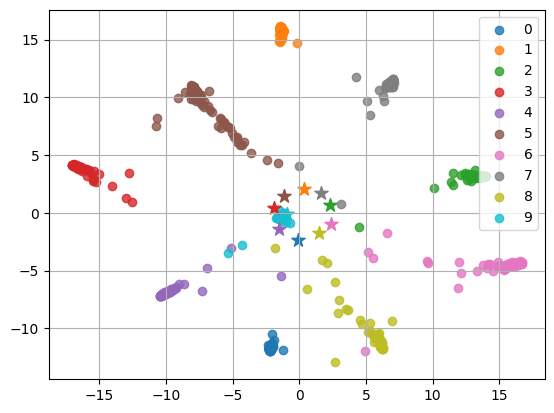

In [15]:
import matplotlib as mpl
cmap = mpl.colormaps["tab10"]
fig, axs = plt.subplots()
plot_subsample = latent[:1000]
plot_subsample_labels = label[:1000]
for i in range(10):
    mask = plot_subsample_labels==i
    axs.scatter(plot_subsample[mask,0], plot_subsample[mask,1], color=cmap(i), label=str(i), alpha=0.8)
for i in range(10):
    point = state.params["latent_features"]["kernel"][:,i]
    print(point)
    axs.scatter(point[0], point[1], color=cmap(i), marker='*',s=100)
axs.legend(loc="upper right")
axs.grid()

In [14]:
# TODO Add center loss